## モデル概要

LSTMネットワークによって時系列データの特徴を抽出し、その出力をXGBoostの回帰モデルに入力するハイブリッド構成です。

### 具体的な流れ

1. **LSTMによる時系列特徴抽出**  
   - 時系列データから重要なパターンやトレンドをLSTMで学習し、特徴ベクトルを生成

2. **XGBoostによる回帰予測**  
   - LSTMが抽出した特徴をXGBoostに入力し、回帰予測を行う

### 目的

- LSTMの強みである時系列の長期依存性の把握
- XGBoostの優れた非線形回帰性能・過学習抑制能力
- を組み合わせることで、より高い予測精度と汎化性能の両立を目指します。


In [18]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, LayerNormalization, Add, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam
from tensorflow.keras.optimizers import Adam, AdamW
from keras.regularizers import l2
from tensorflow.keras import backend as K
from random import choice
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

## データ処理およびLSTMモデル部分について

本コードにおけるデータ処理およびLSTMモデルの構築・学習部分は、`lstm.py` と同一の実装を用いる  
詳細な処理内容やモデル構造については、`lstm.py` を参照してください

---

`lstm.py` には以下が含まれています：

- データの前処理・スケーリング  
- LSTMモデルのレイヤー構成  
- 学習時のコールバック設定（EarlyStoppingなど）  
- モデルのコンパイルおよび学習処理  



In [53]:
# 特徴量作成（ラグ・移動統計など）
df['体温_lag1'] = df['体温'].shift(1)
df['室温_lag1'] = df['室温']
# --- データ準備 ---
df = pd.read_csv("../datasets/ring_data.csv")

# 特徴量作成（ラグ・移動統計など）
df['体温_lag1'] = df['体温'].shift(1)
df['室温_lag1'] = df['室温'].shift(1)
df['delta_temp'] = df['室温'] - df['体温']
df['delta_temp_lag1'] = df['室温_lag1'] - df['体温_lag1']
df['体温_ma3'] = df['体温'].rolling(window=3).mean()
df['体温_var3'] = df['体温'].rolling(window=3).var()
df['室温_ma3'] = df['室温'].rolling(window=3).mean()
df['室温_var3'] = df['室温'].rolling(window=3).var()

df.dropna(inplace=True)

# 特徴量定義
features = [
    '体温', '体温_lag1',  '体温_ma3', '体温_var3', 
    '室温', '室温_lag1',  '室温_ma3', '室温_var3', 
    'delta_temp', 'delta_temp_lag1',  'アンケート'
]
target = '適温'

# 元データ抽出
X_raw = df[features].values
y_raw = df[[target]].values

# データ分割
X_train_raw, X_temp_raw, y_train_raw, y_temp_raw = train_test_split(
    X_raw, y_raw, test_size=0.4, shuffle=False, random_state=42
)
# さらに検証用とテスト用に分割
X_val_raw, X_test_raw, y_val_raw, y_test_raw = train_test_split(
    X_temp_raw, y_temp_raw, test_size=0.5, shuffle=False, random_state=42
)

# ノイズによるデータ拡張
noise_std = 0.01 * np.std(X_train_raw, axis=0)
noise = np.random.normal(loc=0.0, scale=noise_std, size=X_train_raw.shape)
X_train_aug = X_train_raw + noise
y_train_aug = y_train_raw.copy()

# 学習データを拡張
X_train_combined = np.vstack([X_train_raw, X_train_aug])
y_train_combined = np.vstack([y_train_raw, y_train_aug])

# スケーリング
feature_scaler = MinMaxScaler()
X_train_scaled = feature_scaler.fit_transform(X_train_combined)
X_val_scaled = feature_scaler.transform(X_val_raw)
X_test_scaled = feature_scaler.transform(X_test_raw)

target_scaler = MinMaxScaler()
y_train_scaled = target_scaler.fit_transform(y_train_combined)
y_val_scaled = target_scaler.transform(y_val_raw)
y_test_scaled = target_scaler.transform(y_test_raw)

# シーケンス生成関数
def create_sequences(X, y, time_steps=3):
    n_samples = len(X) - time_steps
    X_seq = np.array([X[i:i+time_steps] for i in range(n_samples)])
    y_seq = y[time_steps:]
    return X_seq, y_seq

# シーケンス生成
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, time_steps=3)
X_val_seq, y_val_seq = create_sequences(X_val_scaled, y_val_scaled, time_steps=3)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, time_steps=3)

# --- LSTM モデル学習 ---
epochs_list = [60,90,120]
batch_sizes = [4, 8, 16]
lstm_units = [60,90,120]
dropout_rates = [0.001,0.01,0.05]
l2_reg_strengths = [0.01,0.05,0.1]
best_loss = float('inf')
best_params = None
best_model = None

for _ in range(15):
    epochs = choice(epochs_list)
    batch_size = choice(batch_sizes)
    units = choice(lstm_units)
    dropout = choice(dropout_rates)
    l2_reg_strength = choice(l2_reg_strengths)

    print(f"Training with Epochs: {epochs}, Batch Size: {batch_size}, Units: {units}, Dropout: {dropout}, L2: {l2_reg_strength}")

    # --- モデル構築 ---
    input_layer = Input(shape=(X_train_seq.shape[1], X_train_seq.shape[2])) #(タイムステップ数, 特徴量数)

    # 双方向LSTM（1層目）#(batch_size, timesteps, units*2)
    out1 = Bidirectional(LSTM(units, return_sequences=True, kernel_regularizer=l2(l2_reg_strength)))(input_layer)
    input2 = LayerNormalization()(out1)

    # 双方向LSTM（2層目） #
    out2 = Bidirectional(LSTM(units // 2, return_sequences=False, kernel_regularizer=l2(l2_reg_strength)))(input2)
    x = LayerNormalization()(out2)

    residual = x
    residual_units = K.int_shape(residual)[-1]  # 静的にユニット数を取得
    x = Dense(
        residual_units, 
        activation='gelu', 
        kernel_regularizer=l2(l2_reg_strength)
        )(x)
    residual_added = Add()([x, residual])
    resi_seq = LayerNormalization()(residual_added)
    out_resi = Dropout(dropout)(resi_seq)

    # 最終出力
    output = Dense(1)(out_resi)    
    # モデル定義
    model = Model(inputs=input_layer, outputs=output)

    # コンパイル（AdamW）
    model.compile(
        optimizer=AdamW(learning_rate=1e-3, weight_decay=1e-5),
        loss='mse')
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=0)

    # 学習
    history = model.fit(
        X_train_seq, y_train_seq,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_val_seq, y_val_seq),
        callbacks=[early_stopping, reduce_lr],
        verbose=0
    )

    val_loss = history.history['val_loss'][-1]
    print(f"Validation Loss: {val_loss}")

    if val_loss < best_loss:
        best_loss = val_loss
        best_params = (epochs, batch_size, units, dropout, l2_reg_strength)
        best_model = model
        best_history = history

print(f"Best Params: {best_params}")
print(f"Best Val Loss: {best_loss}")

Training with Epochs: 120, Batch Size: 4, Units: 60, Dropout: 0.001, L2: 0.01
Validation Loss: 0.004790520295500755
Training with Epochs: 90, Batch Size: 16, Units: 120, Dropout: 0.001, L2: 0.1
Validation Loss: 0.008851866237819195
Training with Epochs: 120, Batch Size: 8, Units: 90, Dropout: 0.001, L2: 0.01
Validation Loss: 0.009737681597471237
Training with Epochs: 120, Batch Size: 4, Units: 90, Dropout: 0.001, L2: 0.05
Validation Loss: 0.005140930879861116
Training with Epochs: 120, Batch Size: 16, Units: 60, Dropout: 0.001, L2: 0.1
Validation Loss: 0.0058683729730546474
Training with Epochs: 60, Batch Size: 16, Units: 60, Dropout: 0.001, L2: 0.05
Validation Loss: 0.018419859930872917
Training with Epochs: 90, Batch Size: 4, Units: 90, Dropout: 0.01, L2: 0.1
Validation Loss: 0.005979170091450214
Training with Epochs: 120, Batch Size: 16, Units: 60, Dropout: 0.05, L2: 0.05
Validation Loss: 0.006750829517841339
Training with Epochs: 60, Batch Size: 16, Units: 120, Dropout: 0.05, L2: 0

## LSTM特徴抽出とXGBoostによるハイブリッド学習・予測

###  LSTMによる特徴抽出
- LSTMモデル（`best_model`）の中間層出力を特徴ベクトルとして抽出 
- これにより、時系列データの潜在的なパターンを捉えた特徴量を生成 
- 抽出した特徴を訓練データおよびテストデータそれぞれに対して計算

###  元データとの同期・結合
- LSTMの時系列入力に合わせて元データ（`X_raw`, `y_raw`）の時間軸を調整（`time_steps=3`分をカット）
- 元データの静的特徴とLSTM抽出特徴を特徴軸に結合し、新たな特徴行列を作成
- これにより、静的な情報と時系列の動的特徴を融合したデータセットを準備

###  XGBoostによる学習と予測
- 結合した特徴を用いてXGBoost回帰モデルを構築
- ハイパーパラメータは`n_estimators=150`、`max_depth=7`、`learning_rate=0.05`、`random_state=42`に設定  
- 訓練データでモデルを学習し、テストデータに対して予測を実行


In [67]:
# --- LSTM特徴抽出 ---
feature_extractor = Model(inputs=best_model.input, outputs=best_model.layers[-3].output)
X_train_lstm_feat = feature_extractor.predict(X_train)
X_test_lstm_feat = feature_extractor.predict(X_test)

# --- XGBoost用に元データと同期 ---
time_steps = 3
X_raw_cut = X_raw[time_steps:]
y_raw_cut = y_raw[time_steps:]
X_train_static = X_raw_cut[:len(X_train)]
X_test_static = X_raw_cut[-len(X_test):]
X_train_combined = np.hstack([X_train_static, X_train_lstm_feat])
X_test_combined = np.hstack([X_test_static, X_test_lstm_feat])

# --- XGBoost 学習・予測 ---
xgb_model = XGBRegressor(
    n_estimators=150, 
    max_depth=7, 
    learning_rate=0.05, 
    random_state=42)

xgb_model.fit(X_train_combined, y_train)

xgb_preds = xgb_model.predict(X_test_combined)
xgb_preds_inv = target_scaler.inverse_transform(xgb_preds.reshape(-1, 1)).flatten()



10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


### モデルの性能評価と結果の信頼性(lstm.py参照)

XGBoost Mean Squared Error (MSE): 0.3217
XGBoost Root Mean Squared Error (RMSE): 0.5672
XGBoost Mean Absolute Error (MAE): 0.4590
XGBoost R^2 Score: 0.5794


C:\Users\bsksh\AppData\Local\Temp\ipykernel_5260\2702432285.py:27: UserWarning: Glyph 12456 (\N{KATAKANA LETTER E}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\bsksh\AppData\Local\Temp\ipykernel_5260\2702432285.py:27: UserWarning: Glyph 12509 (\N{KATAKANA LETTER PO}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\bsksh\AppData\Local\Temp\ipykernel_5260\2702432285.py:27: UserWarning: Glyph 12483 (\N{KATAKANA LETTER SMALL TU}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\bsksh\AppData\Local\Temp\ipykernel_5260\2702432285.py:27: UserWarning: Glyph 12463 (\N{KATAKANA LETTER KU}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\bsksh\AppData\Local\Temp\ipykernel_5260\2702432285.py:27: UserWarning: Glyph 25613 (\N{CJK UNIFIED IDEOGRAPH-640D}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\bsksh\AppData\Local\Temp\ipykernel_5260\2702432285.py:27: UserWarning: Glyph 22833 (\N{CJK UNIFIED IDEOGRAPH-5931}) missing from font(s) Arial.
  pl

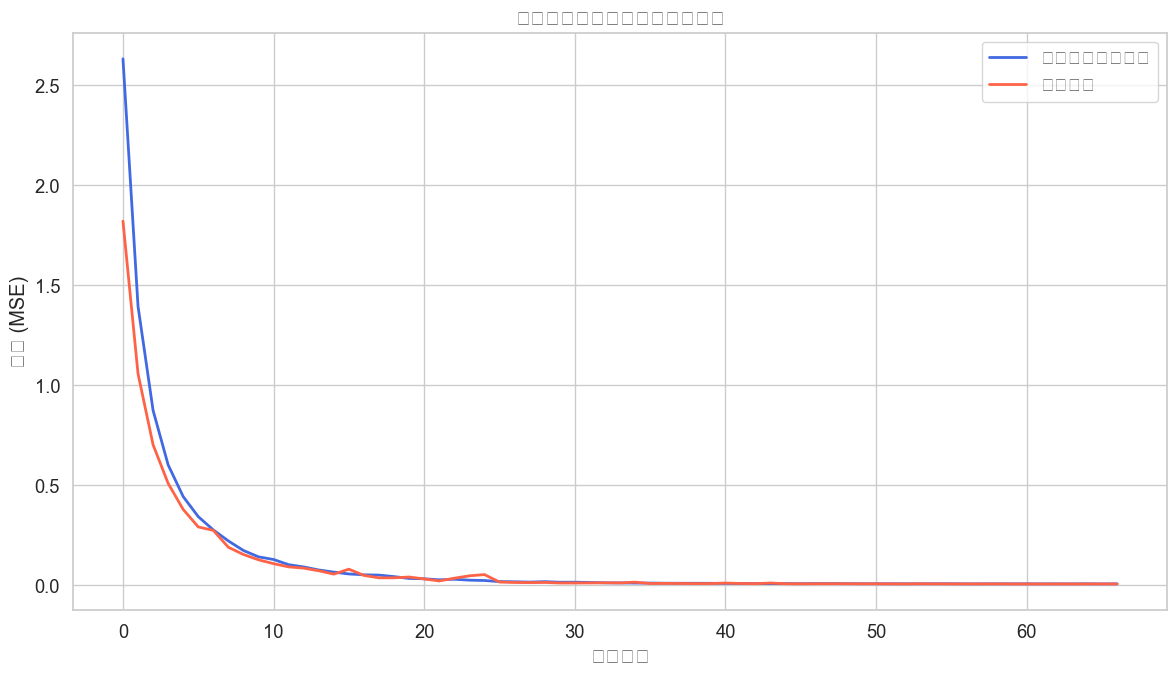

C:\Users\bsksh\AppData\Local\Temp\ipykernel_5260\2702432285.py:39: UserWarning: Glyph 26178 (\N{CJK UNIFIED IDEOGRAPH-6642}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\bsksh\AppData\Local\Temp\ipykernel_5260\2702432285.py:39: UserWarning: Glyph 38291 (\N{CJK UNIFIED IDEOGRAPH-9593}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\bsksh\AppData\Local\Temp\ipykernel_5260\2702432285.py:39: UserWarning: Glyph 12473 (\N{KATAKANA LETTER SU}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\bsksh\AppData\Local\Temp\ipykernel_5260\2702432285.py:39: UserWarning: Glyph 12486 (\N{KATAKANA LETTER TE}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\bsksh\AppData\Local\Temp\ipykernel_5260\2702432285.py:39: UserWarning: Glyph 12483 (\N{KATAKANA LETTER SMALL TU}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\bsksh\AppData\Local\Temp\ipykernel_5260\2702432285.py:39: UserWarning: Glyph 12503 (\N{KATAKANA LETTER PU}) missing from font(s) Arial.
  p

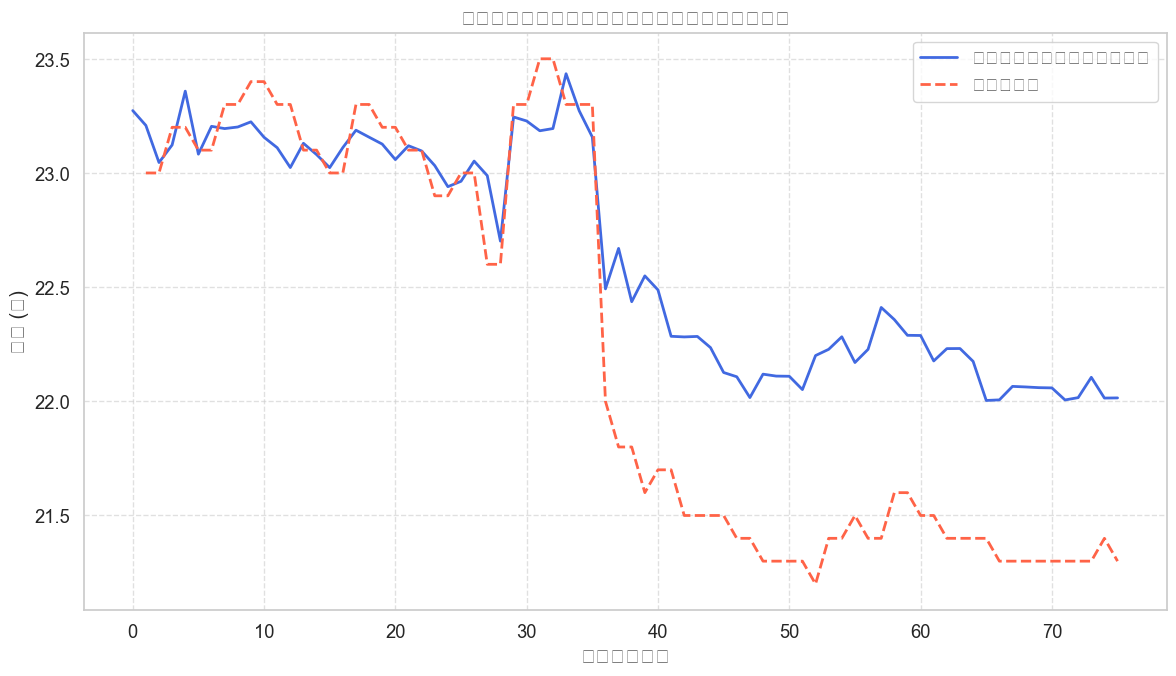

In [68]:
# --- 日本語フォントの設定 ---
plt.rcParams['font.family'] = 'Yu Gothic'  
# NaNでないインデックスだけ抽出
valid_idx = ~np.isnan(actual_temps_inv)

# 精度指標計算
mse = mean_squared_error(actual_temps_inv[valid_idx], xgb_preds_inv[valid_idx])
rmse = np.sqrt(mse)
mae = mean_absolute_error(actual_temps_inv[valid_idx], xgb_preds_inv[valid_idx])
r2 = r2_score(actual_temps_inv[valid_idx], xgb_preds_inv[valid_idx])
print(f"XGBoost Mean Squared Error (MSE): {mse:.4f}")
print(f"XGBoost Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"XGBoost Mean Absolute Error (MAE): {mae:.4f}")
print(f"XGBoost R^2 Score: {r2:.4f}")


sns.set(style="whitegrid", palette="muted", font_scale=1.2)

# --- LSTMのトレーニングと検証損失推移 ---
plt.figure(figsize=(12, 7))
sns.lineplot(data=best_history.history['loss'], label='トレーニング損失', color='royalblue', linewidth=2)
sns.lineplot(data=best_history.history['val_loss'], label='検証損失', color='tomato', linewidth=2)
plt.title('トレーニングと検証の損失推移')
plt.xlabel('エポック')
plt.ylabel('損失 (MSE)')
plt.legend()
plt.tight_layout()
plt.show()

# --- ハイブリッドモデル予測と実測の適温推移グラフ ---
plt.figure(figsize=(12, 7))
sns.lineplot(x=range(len(xgb_preds_inv)), y=xgb_preds_inv, label='ハイブリッドモデル予測適温', color='royalblue', linewidth=2)
sns.lineplot(x=range(len(actual_temps_inv)), y=actual_temps_inv, label='実際の適温', color='tomato', linestyle='--', linewidth=2)
plt.title('ハイブリッドモデル予測適温と実際の適温の比較')
plt.xlabel('時間ステップ')
plt.ylabel('温度 (℃)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()



**CSVファイルへの保存**  
   指定したファイル名（`ring_lstm.csv`）でCSV形式で`.\results`へ保存し、保存パスを出力している


In [69]:
import os


# 評価指標を辞書でまとめる
results_dict = {
    "MSE": [mse],
    "RMSE": [rmse],
    "MAE": [mae],
    "R2": [r2]
}

# DataFrameに変換
results_df = pd.DataFrame(results_dict)

# 保存先ディレクトリ
results_dir = "../results"
os.makedirs(results_dir, exist_ok=True)  # フォルダがなければ作成

# 保存ファイル名
filename = "ring_lstm_xgb.csv"  

# フルパスを作成
filepath = os.path.join(results_dir, filename)

# CSV保存（indexは不要）
results_df.to_csv(filepath, index=False)

print(f"評価結果を保存しました: {filepath}")


評価結果を保存しました: ../results\ring_lstm_xgb.csv
